In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Pillow pour ouvrir et manipuler des images
from PIL import Image

#Les outils pour le deep learning Pytorch
import torch
import torch.nn as nn
from torchvision import models, transforms
#La barre de progression
from tqdm import tqdm

### Le deep learning étant beaucoup de calculs matriciels, le GPU le fait beaucoup mieux que les CPU classiques.

* Sur mon mac(Applce silicon), j'utilise le device `MPS`. `CUDA` de `NVIDIA` eexiste sur les linux et windows
* Si nous avons ni de MPS ni de CUDA on utilisera donc les processeurs lambda


In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé: {device}")

Device utilisé: mps


## Étape 1: Importer les données et explorer le jeu de radiographies

- Nous allons créer un catalogue d'image(un tableau) qui liste où se trouve chaque image et quel est son label si elle en a un
- Afficher quelques exemples (Exploration qualitative)
- Faire une analyse Technique (Résolution et Canaux)
- Distribution des classes (L'équilibre)

In [27]:
#Definition des chemins
base_dir = "." #Répertoire courant
labeled_dir = os.path.join(base_dir, "with_labels") #Répertoire des images étiquetées   
unlabeled_dir = os.path.join(base_dir, "without_label") #Répertoire des images non étiquetées

data = []

#1 Récupération des images labelisées(Cancer ou Normal)
for label in ["cancer", "normal"]:
    folder_path = os.path.join(labeled_dir, label)

    #Lister tous les fichiers dans le répertoire des images labelisées
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            #Dans la description du projet, il est indiqué que les images sont au format PNG mais nous prendons aussi les JPG et JPEG pour généraliser notre code
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                data.append({
                    "filename": filename,
                    "filepath": os.path.join(folder_path, filename),
                    "label": label,
                    "dataset_type": "labeled"
                })

#2 Récupération des images non labelisées
if os.path.exists(unlabeled_dir):
    for filename in os.listdir(unlabeled_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            data.append({
                "filename": filename,
                "filepath": os.path.join(unlabeled_dir, filename),
                "label": "unknown", #Les images non labelisées ont le label "unknown"
                "dataset_type": "unlabeled"
            })

#Tranformation des données en DataFrame pandas
df = pd.DataFrame(data)

print(f"Nombre total d'images: {len(df)}")
print(f"Nombre d'images par type{df['dataset_type'].value_counts()}")
print(f"Nombre d'images par label:\n{df['label'].value_counts()}")
display(df.tail())

Nombre total d'images: 1506
Nombre d'images par typedataset_type
unlabeled    1406
labeled       100
Name: count, dtype: int64
Nombre d'images par label:
label
unknown    1406
cancer       50
normal       50
Name: count, dtype: int64


,filename,filepath,label,dataset_type
1501,66787dcb-65fc-465b-99f8-a5f3df43de8f.jpg,./without_label/66787dcb-65fc-465b-99f8-a5f3df...,unknown,unlabeled
1502,e6f11dd9-7f43-44b2-a92c-0331a75b1479.jpg,./without_label/e6f11dd9-7f43-44b2-a92c-0331a7...,unknown,unlabeled
1503,8b22e623-fe9a-48de-a8a9-326baf91af63.jpg,./without_label/8b22e623-fe9a-48de-a8a9-326baf...,unknown,unlabeled
1504,47abe1b3-9a05-4d39-bae6-f3287dfffa60.jpg,./without_label/47abe1b3-9a05-4d39-bae6-f3287d...,unknown,unlabeled
1505,fe4fdff6-284e-41f9-a55d-81725888b3df.jpg,./without_label/fe4fdff6-284e-41f9-a55d-817258...,unknown,unlabeled


> **Nous constatons déjà que nous n'avons pas de déséquilibre de classe entre les classes labelisées.**

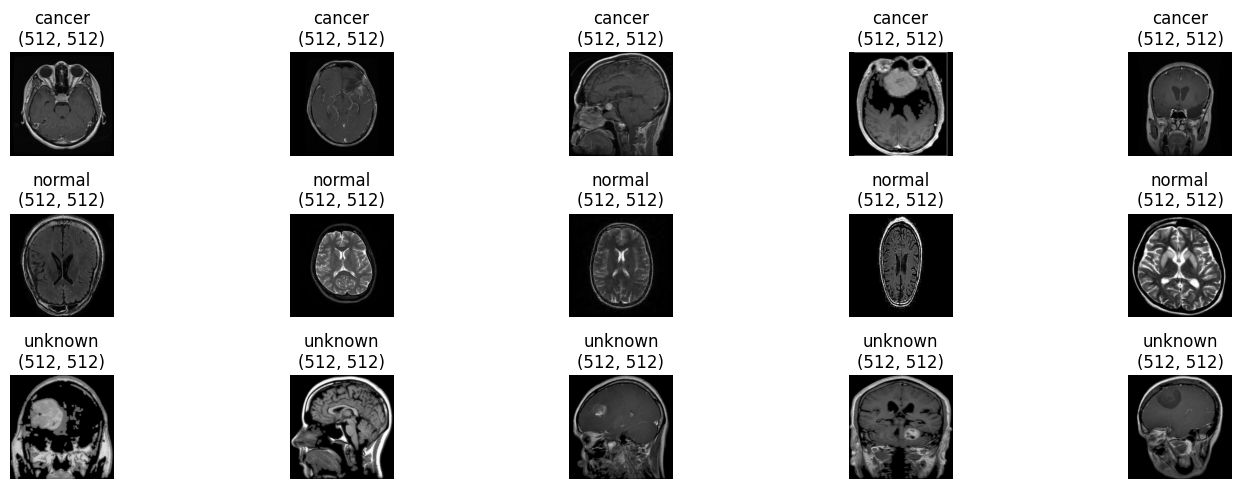

In [28]:
#Définition d'une fonction de visualisation des images
def visualiser_examples(df, categories, n_images=5):
    """
        Fonction qui affiche de façon aléatoire des exemples d'images pour chaque catégorie spécifiée.
        Args:
            df (pd.DataFrame): DataFrame contenant les informations des images.
            categories (list): Liste des catégories à visualiser.
            n_images (int): Nombre d'images à afficher par catégorie.
    """

    plt.figure(figsize=(15, 5))

    for i, category in enumerate(categories):
        #Filtrer le dataframe pour la catégorie actuelle
        subset = df[df["label"]==category]

        if len(subset) > 0:
            #Sélectionner le nombre spécifié d'images aléatoires
            samples = subset.sample(n=min(len(subset), n_images), random_state=42)

            for j, (index, row) in enumerate(samples.iterrows()):
                #Crétation d'une sous case dans la grille
                plt.subplot(len(categories), n_images, i * n_images + j + 1)

                #Ouverture et affichage de l'image
                img = Image.open(row["filepath"])
                plt.imshow(img)
                plt.title(f"{category}\n{img.size}")
                plt.axis("off") #CacheR les axes (0, 10, 20) pour rendre plus joli
    plt.tight_layout()
    plt.show()

#Visualisation des cas de cancer, normaux et non labelisés
visualiser_examples(df, categories=["cancer", "normal", "unknown"], n_images=5)

### Analyse Technique (Résolution et Canaux)

> C'est la partie "Sanity Check" (Vérification de cohérence). 

> Le modèle ResNet attend généralement 3 canaux de couleurs (Rouge, Vert, Bleu - RGB). 

> Si nous des images en niveau de gris (1 canal), il faudra le savoir pour les convertir. 

> De même, si une image fait 10 pixels sur 10, elle est inutilisable.

In [29]:
#Listes pour stocker les informations extraites
widths = []
heights = []
modes = [] #Mode de couleur (RGB, L, RGBA, etc.

print("Analyse des propriétés des images en cours...")

for index, row in df.iterrows():
    try:
        with Image.open(row["filepath"]) as img:
            #Recupérer la taille de l'image
            widths.append(img.width)
            heights.append(img.height)

            #Récupérer le mode (RGB = Couleur, L = Noir & Blanc, RGBA = Transparence)
            modes.append(img.mode)

    except Exception as e:
        print(f"Erreur lors de l'ouverture de l'image {row['filepath']}: {e}")
        widths.append(None)
        heights.append(None)
        modes.append("Erreur")

#Ajout des nouvelles colonnes au DataFrame
df["width"] = widths
df["height"] = heights
df["mode"] = modes


print("Propriétés des images analysées avec succès.")
display(df.head())
    

Analyse des propriétés des images en cours...
Propriétés des images analysées avec succès.


,filename,filepath,label,dataset_type,width,height,mode
0,0f718241-8f63-4b55-81ce-315324b51069.jpg,./with_labels/cancer/0f718241-8f63-4b55-81ce-3...,cancer,labeled,512,512,RGB
1,b6a41ca0-aeea-43a8-b629-7c433cf03143.jpg,./with_labels/cancer/b6a41ca0-aeea-43a8-b629-7...,cancer,labeled,512,512,RGB
2,7e3f6acd-c9cc-440e-ba01-fedab0462fed.jpg,./with_labels/cancer/7e3f6acd-c9cc-440e-ba01-f...,cancer,labeled,512,512,RGB
3,bf7004d5-af81-4cf6-8411-b5105eeecda1.jpg,./with_labels/cancer/bf7004d5-af81-4cf6-8411-b...,cancer,labeled,512,512,RGB
4,05340cd4-3bb2-459d-9937-bf27d52d8351.jpg,./with_labels/cancer/05340cd4-3bb2-459d-9937-b...,cancer,labeled,512,512,RGB


### *Faisons des statistiques histoire de comprendre les données.*

---- Mode de couleur des images ----
mode
RGB    1506
Name: count, dtype: int64
---- Dimensions des images ----
        width  height
count  1506.0  1506.0
mean    512.0   512.0
std       0.0     0.0
min     512.0   512.0
25%     512.0   512.0
50%     512.0   512.0
75%     512.0   512.0
max     512.0   512.0


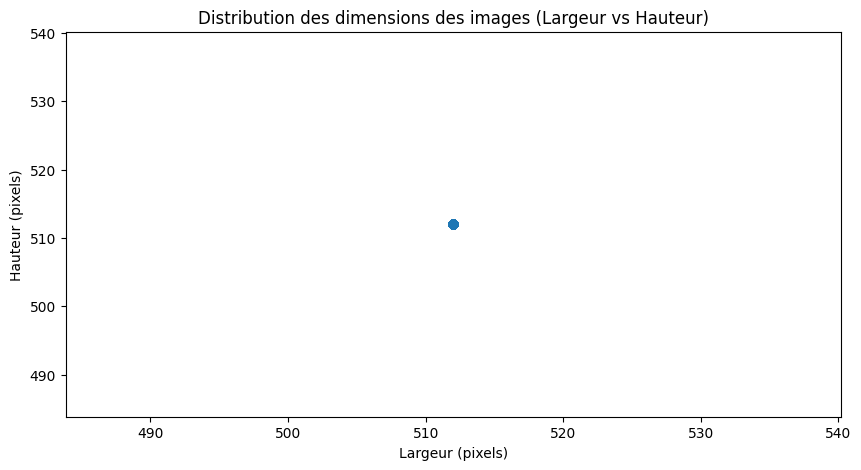

In [30]:
#1 Veirification des modes de couleur des images
print("---- Mode de couleur des images ----")
print(df["mode"].value_counts())

#2 Vérification des dimensions des images
print("---- Dimensions des images ----")
print(df[["width", "height"]].describe())

#Visualisation des distributions des largeurs et hauteurs des images
plt.figure(figsize=(10, 5))
plt.scatter(df["width"], df["height"], alpha=0.5)
plt.title("Distribution des dimensions des images (Largeur vs Hauteur)")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Hauteur (pixels)")
plt.show()

- Nous constatons que toutes les images ont la même hauteur et largeur, comme mentionné dans le document descriptif de simages.
`La confiance n'exclue pas le contrôle`
- Également toutes les images sont en RGB, bonne nouvelle pour ResNet

**Notre dataset est donc propre et standardisé.**

### Distribution des classes (L'équilibre)
Enfin, regardons si on a beaucoup de données ou pas. C'est crucial pour savoir si l'apprentissage sera difficile.

/var/folders/9h/3s_l21w96jb57blfbh1702100000gn/T/ipykernel_88845/1954562147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


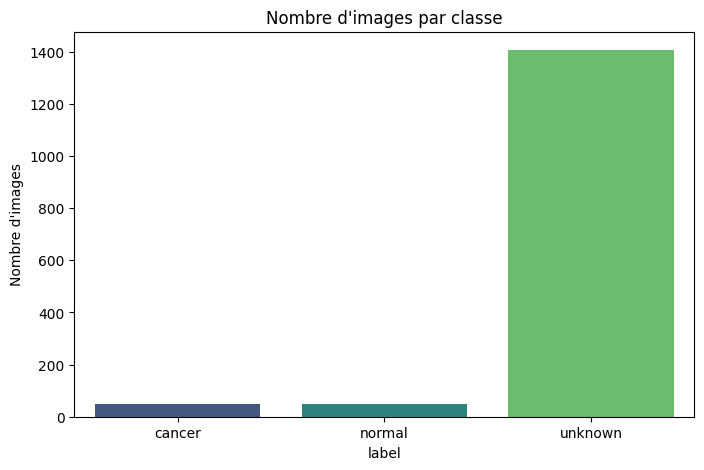

label
unknown    1406
cancer       50
normal       50
Name: count, dtype: int64


In [31]:
plt.figure(figsize=(8, 5))
# On compte combien d'images il y a pour chaque label
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Nombre d'images par classe")
plt.ylabel("Nombre d'images")
plt.show()

# Affichons les chiffres exacts
print(df['label'].value_counts())

### Conclusion de l'étape 1

Après la **première étape**, nous constatons que :

1. **Images labelisées**  
   - Parmi les images labelisées, il **n’y a pas de déséquilibre entre les classes**.  
   - Cependant, le nombre d’images labelisées est **très faible** par rapport aux images non labelisées.

2. **Images non labelisées**  
   - Une grande partie des données **n’est pas labelisée**, ce qui complique l’entraînement du modèle supervisé, nous utiliserons donc une approche **SSL**.
